<a href="https://colab.research.google.com/github/dundurlunka/ml-grand-slam/blob/main/ml_grand_slam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Read data from github

In [1]:
import pandas as pd
import numpy as np

import sys
import csv

In [2]:
csv.field_size_limit(sys.maxsize)

points = pd.read_csv('./charting-m-points-from-2017.csv', quoting=csv.QUOTE_NONE, encoding = 'ISO-8859-1')
matches = pd.read_csv('./charting-m-matches.csv', quoting=csv.QUOTE_NONE, encoding = 'ISO-8859-1')

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (8,9,29) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Merge the two datasets together by match_id

In [3]:
joinedData = pd.merge(
    matches,
    points,
    how="inner",
    on='match_id',
)

In [4]:
df_obj = joinedData.select_dtypes(['object'])
joinedData[df_obj.columns] = df_obj.apply(lambda x: x.str.strip())

Select relevant columns from dataframe


In [5]:
joinedData.columns = joinedData.columns.to_series().apply(lambda x: x.strip())
joinedData = joinedData.loc[:, ['Player 1', 'Player 2', 'Tournament', 'Pl 1 hand', 'Pl 2 hand', 'Surface', 'Set1','Set2', 'Gm1', 'Gm2', 'Pts', 'Serving', '1st', '2nd', 'isAce', 'isUnret']]

In [6]:
joinedData['isAce'] = joinedData['isAce'] | joinedData['isUnret']
joinedData = joinedData.drop(columns=['isUnret', 'isAce'])

In [7]:
tennis_players = ['Daniil Medvedev', 'Alexander Zverev', 'Roger Federer', 'Dominic Thiem', 'Nick Kyrgios', 'Novak Djokovic', 'Rafael Nadal', 'Stefanos Tsitsipas', 'Casper Ruud', 'Grigor Dimitrov']
tennis_players_initials = [''.join([x[0].upper() for x in fullname.split(' ')]) for fullname in tennis_players]
joinedData = joinedData.loc[((joinedData['Player 1'].isin(tennis_players)) | (joinedData['Player 2'].isin(tennis_players)))]
joinedData = joinedData.loc[joinedData['Serving'].isin(tennis_players_initials)]

In [8]:
joinedData[['Pts1', 'Pts2']] = joinedData['Pts'].str.split('-', expand=True)
joinedData = joinedData.drop('Pts', axis='columns')

Separate the columns into new columns that are specific for Server and Returner.

In [9]:
server_names = []
returner_names = []
pointsServer = []
pointsReturner = []
gamesServer = []
gamesReturner = []
setsServer = []
setsReturner = []
handReturner = []
for index, row in joinedData.iterrows():
    if ''.join([x[0].upper() for x in row['Player 1'].split(' ')]) == row['Serving']:
      server_names.append(row['Player 1'])
      returner_names.append(row['Player 2'])
      pointsServer.append(row['Pts1'])
      pointsReturner.append(row['Pts2'])
      gamesServer.append(row['Gm1'])
      gamesReturner.append(row['Gm2'])
      setsServer.append(row['Set1'])
      setsReturner.append(row['Set2'])
      handReturner.append(row['Pl 2 hand'])
    elif ''.join([x[0].upper() for x in row['Player 2'].split(' ')]) == row['Serving']:
      server_names.append(row['Player 2'])
      returner_names.append(row['Player 1'])
      pointsServer.append(row['Pts2'])
      pointsReturner.append(row['Pts1'])
      gamesServer.append(row['Gm2'])
      gamesReturner.append(row['Gm1'])
      setsServer.append(row['Set2'])
      setsReturner.append(row['Set1'])
      handReturner.append(row['Pl 1 hand'])

joinedData['FullNameServer'] = server_names
joinedData['FullNameReturner'] = returner_names
joinedData['PointsServer'] = pointsServer
joinedData['PointsReturner'] = pointsReturner
joinedData['GamesServer'] = gamesServer
joinedData['GamesReturner'] = gamesReturner
joinedData['SetsServer'] = setsServer
joinedData['SetsReturner'] = setsReturner
joinedData['HandReturner'] = handReturner

joinedData = joinedData.drop(columns=['Player 1', 'Player 2', 'Pts1', 'Pts2', 'Gm1', 'Gm2', 'Set1', 'Set2', 'Pl 1 hand', 'Pl 2 hand', 'Serving'])

Combine the serves into one column with a list of 1 or 2 serves so that it can be exploded into several rows later

In [10]:
joinedData['Serves'] = joinedData.apply(lambda x: list(['f' + str(x['1st']),
                                                        's' + str(x['2nd'])]), axis=1)   

Explode list of first and second serve into separate rows

In [11]:
joinedData = joinedData.explode('Serves')

Add new column indicating whether the serve was first or second

In [12]:
joinedData['IsFirstServe'] = joinedData['Serves'].str[0] == 'f'

Remove 'f' and 's' (first and second serve) that were indicators before the explosion

In [13]:
joinedData['Serves'] = joinedData['Serves'].str[1:]
joinedData = joinedData[(joinedData['Serves'] != 'nan') & (joinedData['Serves'] != '')]
joinedData = joinedData.drop(columns=['1st', '2nd'])

Remove lets

In [14]:
joinedData['Serves'] = joinedData['Serves'].map(lambda x: x.lstrip('c'))

In [15]:
joinedData['FullNameServer'].value_counts()
joinedData['FullNameReturner'].value_counts()

Novak Djokovic        5698
Rafael Nadal          4634
Stefanos Tsitsipas    4454
Daniil Medvedev       4011
Alexander Zverev      3736
                      ... 
Ryan Harrison           72
Daniel Elahi Galan      71
Ugo Humbert             66
Peter Gojowczyk         59
Michael Geerts          49
Name: FullNameReturner, Length: 143, dtype: int64

Extract direction of serve

In [16]:
def extract_serve_direction(row):
  serves_directions_dict = {
      '4': 'Out wide',
      '5': 'Body',
      '6': 'Down the T'
  }

  if len(row['Serves']) > 1 and row['Serves'][1] in ['x', 'd', 'w', 'n', 'g', '!', 'e']:
      return "Fault"
  else:
      return serves_directions_dict.get(row['Serves'][0], 'Body')

joinedData['Direction'] = joinedData.apply(extract_serve_direction, axis=1)
joinedData = joinedData.drop(columns='Serves')

## Remove faults from dataframe

In [17]:
joinedData = joinedData[joinedData['Direction'] != 'Fault']

In [18]:
joinedData.to_csv('wrangled-data.csv')

# Start of machine learning

### Data exploration

In [19]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

In [36]:
joinedData = pd.read_csv('./wrangled-data.csv')
joinedData = joinedData.drop(columns=['Unnamed: 0'])
pd.set_option('display.max_rows', 500)
joinedData.head(500)

,Tournament,Surface,FullNameServer,FullNameReturner,PointsServer,PointsReturner,GamesServer,GamesReturner,SetsServer,SetsReturner,HandReturner,IsFirstServe,Direction
0,Tour Finals,Hard,Novak Djokovic,Casper Ruud,0,0,0,0,0,0,R,False,Out wide
1,Tour Finals,Hard,Novak Djokovic,Casper Ruud,0,15,0,0,0,0,R,False,Down the T
2,Tour Finals,Hard,Novak Djokovic,Casper Ruud,15,15,0,0,0,0,R,True,Out wide
3,Tour Finals,Hard,Novak Djokovic,Casper Ruud,30,15,0,0,0,0,R,False,Body
4,Tour Finals,Hard,Novak Djokovic,Casper Ruud,40,15,0,0,0,0,R,True,Out wide
5,Tour Finals,Hard,Casper Ruud,Novak Djokovic,0,0,0,1,0,0,R,False,Down the T
6,Tour Finals,Hard,Casper Ruud,Novak Djokovic,0,15,0,1,0,0,R,False,Body
7,Tour Finals,Hard,Casper Ruud,Novak Djokovic,15,15,0,1,0,0,R,False,Body
8,Tour Finals,Hard,Casper Ruud,Novak Djokovic,30,15,0,1,0,0,R,False,Down the T
9,Tour Finals,Hard,Casper Ruud,Novak Djokovic,40,15,0,1,0,0,R,False,Body


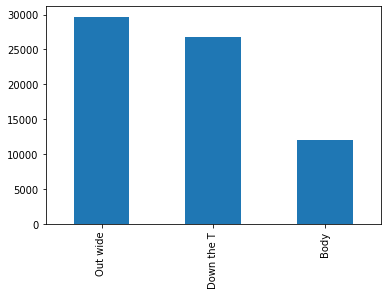

In [37]:
joinedData['Direction'].value_counts().plot(kind='bar')

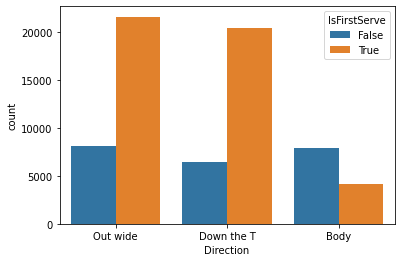

In [38]:
sns.countplot(
    x = 'Direction',
    hue = 'IsFirstServe',
    data = joinedData,
)

## Pre-processing

In [39]:
X = joinedData.drop(columns=['Direction'])
y = joinedData['Direction']

### One hot encoding attributes

In [40]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

categorical_columns = ['Surface', 'FullNameServer', 'FullNameReturner', 'PointsServer', 'PointsReturner', 'HandReturner', 'Tournament']

encoded_X = pd.get_dummies(X, columns=categorical_columns)

In [41]:
encoded_X.to_csv('encoded_attributes.csv')

### Label encoding the label

In [42]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
encoded_y = le.fit_transform(y)

### Splitting into train test

In [43]:
X_train, X_test, y_train, y_test = train_test_split(encoded_X, encoded_y)

## MinMax Scaling

In [34]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression

scaler = MinMaxScaler()
scaler.fit(encoded_X)
scaled_encoded_X_train = scaler.transform(X_train)
scaled_encoded_X_test = scaler.transform(X_test)

regression = LogisticRegression(C=100, max_iter=100000, multi_class='multinomial', solver='newton-cg').fit(scaled_encoded_X_train, y_train)

train_score = regression.score(scaled_encoded_X_train, y_train)
test_score = regression.score(scaled_encoded_X_test, y_test)

print(f'train score: {train_score}')
print(f'test score: {test_score}')

train score: 0.4742498445273632
test score: 0.45723780096776073


In [35]:
pd.set_option('display.max_rows', 500)
joinedData.head(500)

,Unnamed: 0,Tournament,Surface,FullNameServer,FullNameReturner,PointsServer,PointsReturner,GamesServer,GamesReturner,SetsServer,SetsReturner,HandReturner,IsFirstServe,Direction
0,637,Tour Finals,Hard,Novak Djokovic,Casper Ruud,0,0,0,0,0,0,R,False,Out wide
1,638,Tour Finals,Hard,Novak Djokovic,Casper Ruud,0,15,0,0,0,0,R,False,Down the T
2,639,Tour Finals,Hard,Novak Djokovic,Casper Ruud,15,15,0,0,0,0,R,True,Out wide
3,640,Tour Finals,Hard,Novak Djokovic,Casper Ruud,30,15,0,0,0,0,R,False,Body
4,641,Tour Finals,Hard,Novak Djokovic,Casper Ruud,40,15,0,0,0,0,R,True,Out wide
5,642,Tour Finals,Hard,Casper Ruud,Novak Djokovic,0,0,0,1,0,0,R,False,Down the T
6,643,Tour Finals,Hard,Casper Ruud,Novak Djokovic,0,15,0,1,0,0,R,False,Body
7,644,Tour Finals,Hard,Casper Ruud,Novak Djokovic,15,15,0,1,0,0,R,False,Body
8,645,Tour Finals,Hard,Casper Ruud,Novak Djokovic,30,15,0,1,0,0,R,False,Down the T
9,646,Tour Finals,Hard,Casper Ruud,Novak Djokovic,40,15,0,1,0,0,R,False,Body


## KNN

In [28]:
def plot_knn_scores(ks):
    train_scores = []
    test_scores = []
    
    for k in ks:
        clf = KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train)

        print('finding scores for ' + str(k) + ' k neares neighbours')

        train_score = clf.score(X_train, y_train)
        test_score = clf.score(X_test, y_test)              

        print('found scores for ' + str(k) + ' k neares neighbours\n' + f'train_score: {train_score}\n' + f'test_score: {test_score}')

        train_scores.append(train_score)
        test_scores.append(test_score)

    plt.figure(figsize=(10, 6))
    plt.plot(ks, train_scores, color='blue', label='train score')
    plt.plot(ks, test_scores, color='green', label='test score')
    plt.legend()

In [29]:
plot_knn_scores(range(1, 15, 2))

finding scores for 1 k neares neighbours
found scores for 1 k neares neighbours
train_score: 1.0
test_score: 0.3790007578849181
finding scores for 3 k neares neighbours
found scores for 3 k neares neighbours
train_score: 0.6612445584577115
test_score: 0.3625604850463476
finding scores for 5 k neares neighbours
found scores for 5 k neares neighbours
train_score: 0.5992304104477612
test_score: 0.38354806739345887
finding scores for 7 k neares neighbours


KeyboardInterrupt: ignored

## Logistic regression

In [30]:
from sklearn.linear_model import LogisticRegression, OneVsRestClassifier

def plot_logistic_regression_scores(cs):
    train_scores = []
    test_scores = []
    
    for c in cs:
        regression = OneVsRestClassifier(LogisticRegression(C=c)).fit(encoded_X_train, encoded_y_train)

        print(f'finding scores for c={c}')

        train_score = regression.score(X_train, y_train)
        test_score = regression.score(X_test, y_test)              

        print(f'found train score for c={c}: {train_score}')

        train_scores.append(train_score)
        test_scores.append(test_score)

    plt.figure(figsize=(10, 6))
    plt.plot(cs, train_scores, color='blue', label='train score')
    plt.plot(cs, test_scores, color='green', label='test score')
    plt.legend()

finding scores for c=0.001
found train score for c=0.001: 0.43050373134328357
finding scores for c=0.01
found train score for c=0.01: 0.43050373134328357
finding scores for c=0.1
found train score for c=0.1: 0.43050373134328357
finding scores for c=1
found train score for c=1: 0.43050373134328357
finding scores for c=10
found train score for c=10: 0.43050373134328357
finding scores for c=1000
found train score for c=1000: 0.43050373134328357
finding scores for c=10000
found train score for c=10000: 0.43050373134328357


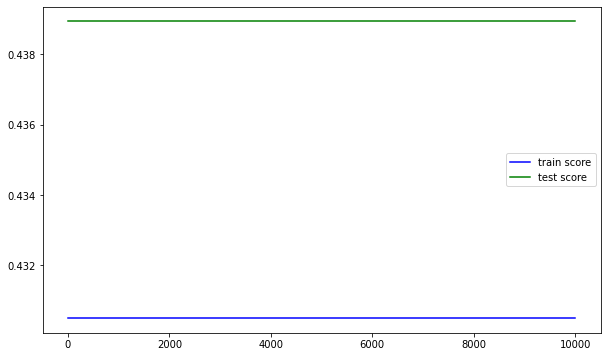

In [31]:
plot_logistic_regression_scores([0.001, 0.01, 0.1, 1, 10, 1000, 10000])

In [ ]:
# pd.set_option('display.max_rows', 500)
# joinedData.head(500)